In [47]:
# Importing required liberies
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [48]:
# Load the data set
df = pd.read_csv("Dataset_Uber Traffic.csv")

In [49]:
df.head(5)

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [50]:
df.shape

(48120, 4)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


##### Data Cleaning 

In [52]:
df.isnull().sum()


DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

we see no null values in data

In [53]:
df.duplicated().sum()

0

we see no duplicate values in data

In [54]:
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [55]:
df.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [56]:
# Convert the 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%d/%m/%y %H:%M")

# Create a new column with just the hourly timestamp
df['Hour'] = df['DateTime'].dt.floor('H')

# Group by 'Junction' and 'Hour' and sum the vehicle counts
hourly_traffic = df.groupby(['Junction', 'Hour'])['Vehicles'].sum().reset_index()

In [57]:
hourly_traffic.head()

,Junction,Hour,Vehicles
0,1,2015-11-01 00:00:00,15
1,1,2015-11-01 01:00:00,13
2,1,2015-11-01 02:00:00,10
3,1,2015-11-01 03:00:00,7
4,1,2015-11-01 04:00:00,9


In [58]:
scaler = StandardScaler()
hourly_traffic['Vehicles_Standardized'] = scaler.fit_transform(hourly_traffic[['Vehicles']])

In [59]:
hourly_traffic.head()

,Junction,Hour,Vehicles,Vehicles_Standardized
0,1,2015-11-01 00:00:00,15,-0.375489
1,1,2015-11-01 01:00:00,13,-0.471875
2,1,2015-11-01 02:00:00,10,-0.616454
3,1,2015-11-01 03:00:00,7,-0.761034
4,1,2015-11-01 04:00:00,9,-0.664648


In [60]:
# Generate time-based features
df['HourOfDay'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek  # Monday = 0, Sunday = 6
df['Month'] = df['DateTime'].dt.month


In [61]:
# Binary indicator for weekends
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Sort by Junction and DateTime to maintain temporal order
df.sort_values(by=['Junction', 'DateTime'], inplace=True)

# Create lag features (1, 2, and 3 hours prior traffic)
df['Lag_1hr'] = df.groupby('Junction')['Vehicles'].shift(1)
df['Lag_2hr'] = df.groupby('Junction')['Vehicles'].shift(2)
df['Lag_3hr'] = df.groupby('Junction')['Vehicles'].shift(3)


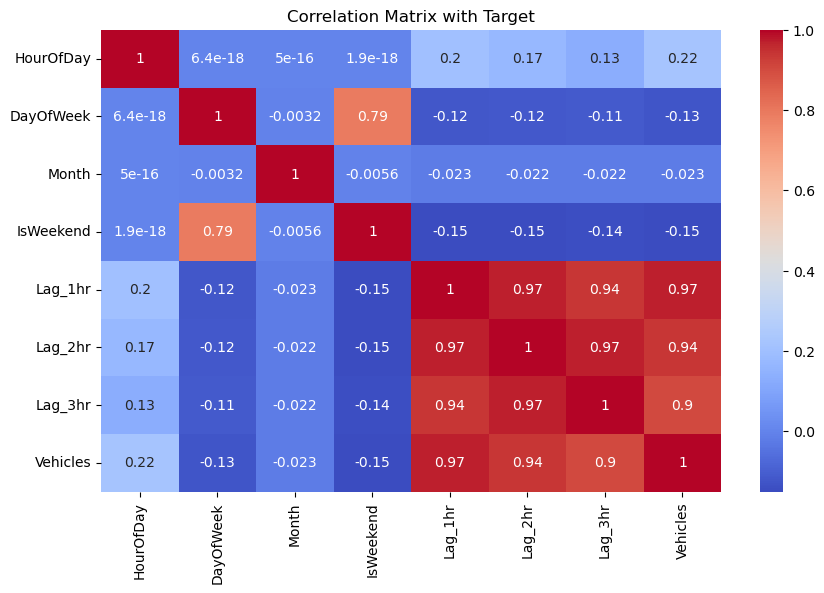

In [63]:
# Define target and features
target = 'Vehicles'
features = [
    'HourOfDay', 'DayOfWeek', 'Month', 'IsWeekend',
    'Lag_1hr', 'Lag_2hr', 'Lag_3hr'
]

X = df[features]
y = df[target]

df[features] = df[features].fillna(method='bfill') 

# Correlation Matrix
plt.figure(figsize=(10, 6))
corr = df[features + [target]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix with Target")
plt.show()




In [65]:
df = df.dropna(subset=features + [target])

In [77]:
correlations = df[features + [target]].corr()[target].drop(target)

# Select top 5 most correlated features
top_features_corr = correlations.abs().sort_values(ascending=False).head(5).index.tolist()

# Use only those features
X_filtered = df[top_features_corr]
print("Top features by correlation:", top_features_corr)

Top features by correlation: ['Lag_1hr', 'Lag_2hr', 'Lag_3hr', 'HourOfDay', 'IsWeekend']
